# ChIP AML PiPeline v2

In [1]:
import os
import pandas as pd

import itertools
from scipy import stats
import numpy as np

from genepy.epigenetics import chipseq as chip
from genepy.utils import helper, plot
import igv
import SimpSOM as sps
from scipy import stats

import seaborn as sns
from matplotlib import cm
from matplotlib import pyplot as plt
from IPython.display import IFrame
import seaborn as sns
from bokeh.plotting import *
import igv
from collections import Counter

from scipy.special import factorial
from scipy.stats import fisher_exact

import numba
from numba import jit

from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from IPython.display import IFrame

from pybedtools import BedTool
import pyBigWig

output_notebook()
%load_ext autoreload
%autoreload 2

Loading BokehJS ...

In [7]:
project="Cobinding_ChIP"
version="v3"
merging_version="remove_single"
window="150"

In [34]:
merged = pd.read_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/merged_with_annotations.bed.gz', sep='\t')

In [8]:
# or we get the new one
version="4"
merging_version="new"
window="0"

merged = pd.read_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/merged.bed.gz', sep='\t')

In [151]:
#%store -r merged
#%store -r chrombed
#%store -r mergedpeak
#%store -r cols
#%store -r annot
#%store -r version
#%store -r merging_version
#%store -r window
#%store -r crc

In [3]:
cols=8
annot=37

In [4]:
#getting the crcs
crc = helper.fileToList('../data/CRCs.txt')

## Assigning genes

### based on closest expressed gene

In [ ]:
chiphelper.AssignToClosestExpressed()

In [ ]:
### recompute cobinding based on this.

In [ ]:
## redo the plots. do we get better plots?/correlations?...

### based on the ABC model

![](images/ABCtitle.png)

They tested a new model based on and validated by CRISPRi-FlowFISH which is basically able to find enhancer mapping to genes. 
They used it to compute their model's Accuracy and found a 70% accuracy compared to less than 50% for closest expressed gene. 

Way to integrate our HiC data (need ATAC-seq like data as well, but openly available) 


![](images/ABCmodel.png)

In [413]:
# ATAC bam file
! mkdir ../../data/ATACseq/
! gsutil cp gs://amlproject/ATAC/MV411/mergedLibrary/ATAC_MV411_R3.mLb.clN.sorted.ba* ../../data/ATACseq/
    
# ATAC broad peaks (just in case)
! gsutil cp gs://amlproject/ATAC/MV411/mergedReplicate/macs/broadPeak/ATAC_MV411_R3*.broadPeak ../../data/ATACseq/

# INPUT bam
!gsutil cp "gs://amlproject/Chip/cobinding/bwa/mergedLibrary/mp845-MV411-INPUT_R1.mLb.clN.sorted.ba*" ../../data/ref/

# H3K27ac Bam
!gsutil cp gs://amlproject/Chip/cobinding/bwa/mergedLibrary/mp702* ../../data/bams/

# Making expression file
!wget https://ndownloader.figshare.com/files/26261476
!mv 26261476 ../../data/expression.csv
reads = pd.read_csv('../../data/expression.csv', index_col=0)
reads = reads.loc['ACH-000045']
reads.index = [i.split(' (')[0] for i in reads.index]
reads.to_csv('../../data/MV411_expression.tsv',sep='\t', header=False)

## download HIC:
! wget ftp://ftp.broadinstitute.org/outgoing/lincRNA/average_hic/average_hic.v2.191020.tar.gz
! mkdir ../../data/hic
! mv average_hic.v2.191020.tar.gz ../../data/hic/
! tar -xf ../../data/hic/average_hic.v2.191020.tar.gz
! mv "chr"* ../../data/hic/


Copying gs://amlproject/ATAC/MV411/mergedLibrary/ATAC_MV411_R3.mLb.clN.sorted.bam...
- [1 files][  1.7 GiB/  1.7 GiB]   80.6 MiB/s                                   
Operation completed over 1 objects/1.7 GiB.                                      
CommandException: No URLs matched: gs://amlproject/ATAC/MV411/mergedReplicate/macs/broadPeak/ATAC_MV411_R3*.broadPeak


In [3]:
ls ../../data/hic/chr1

chr1.KRnorm.gz  chr1.KRobserved.gz


In [531]:
! tar -xf ../../data/hic/average_hic.v2.191020.tar.gz
! mv "chr"* ../../data/hic/

In [430]:
! macs3 callpeak -B -t ../../data/ATACseq/ATAC_MV411_R3.mLb.clN.sorted.bam -c ../../data/ref/mp845-MV411-INPUT_R1.mLb.clN.sorted.bam --nomodel -n ATAC_R3 --outdir ../../data/ATACseq/ -f BAMPE --call-summits 

INFO  @ Thu, 01 Apr 2021 15:22:58: 
# Command line: callpeak -B -t ../../data/ATACseq/ATAC_MV411_R3.mLb.clN.sorted.bam -c ../../data/ref/mp845-MV411-INPUT_R1.mLb.clN.sorted.bam --nomodel -n ATAC_R3 --outdir ../../data/ATACseq/ -f BAMPE --call-summits
# ARGUMENTS LIST:
# name = ATAC_R3
# format = BAMPE
# ChIP-seq file = ['../../data/ATACseq/ATAC_MV411_R3.mLb.clN.sorted.bam']
# control file = ['../../data/ref/mp845-MV411-INPUT_R1.mLb.clN.sorted.bam']
# effective genome size = 2.70e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 1000 bps and 10000 bps
# Broad region calling is off
# Paired-End mode is on
# Searching for subpeak summits is on
 
INFO  @ Thu, 01 Apr 2021 15:22:58: #1 read fragment files...

INFO  @ Thu, 01 Apr 2021 15:51:24: #4 Write output xls file... ../../data/ATACseq/ATAC_R3_peaks.xls 
INFO  @ Thu, 01 Apr 2021 15:51:24: #4 Write peak in narrowPeak format file... ../../data/ATACseq/ATAC_R3_peaks.narrowPeak 
INFO  @ Thu, 01 Apr 2021 15:51:25: #4 Write summits bed file... ../../data/ATACseq/ATAC_R3_summits.bed 
INFO  @ Thu, 01 Apr 2021 15:51:25: Done! 


In [20]:
import sys 
sys.path.append('../src/ABC-Enhancer-Gene-Prediction/src')
from peaks import *

In [474]:
os.makedirs(os.path.join("../results/ABC_output/Peaks/"), exist_ok=True)
make_candidate_regions_from_peaks(macs_peaks = "../../data/ATACseq/ATAC_R3_peaks.narrowPeak", 
                                accessibility_file = "../../data/ATACseq/ATAC_MV411_R3.mLb.clN.sorted.bam", 
                                genome_sizes = "../../genepy/data/hg38.chrom.sizes.txt", 
                                regions_blacklist = "../data/"+project+"/hg38-blacklist.v2.bed",
                                n_enhancers = 25000, 
                                peak_extend = 250, 
                                minPeakWidth=500,
                                regions_whitelist='../data/'+project+'/human_epdnew_l3zqX.bed', # promoters
                                outdir = "../results/ABC_output/Peaks/")

Running: bedtools sort -i ../results/ABC_output/Peaks/ATAC_R3_peaks.narrowPeakATAC_MV411_R3.mLb.clN.sorted.bam.Counts.bed -faidx ../../genepy/data/hg38.chrom.sizes.txt | bedtools merge -i stdin -c 4 -o max | sort -nr -k 4 | head -n 25000 |bedtools intersect -b stdin -a ../../data/ATACseq/ATAC_R3_peaks.narrowPeak -wa |bedtools slop -i stdin -b 250 -g ../../genepy/data/hg38.chrom.sizes.txt |awk '{ l=$3-$2; if (l < 500) { $2 = $2 - int((500-l)/2); $3 = $3 + int((500-l)/2) } print $1 "\t" $2 "\t" $3}' |bedtools sort -i stdin -faidx ../../genepy/data/hg38.chrom.sizes.txt |bedtools merge -i stdin | bedtools intersect -v -wa -a stdin -b ../data/Cobinding_ChIP/hg38-blacklist.v2.bed | cut -f 1-3 | bedtools sort -i stdin -faidx ../../genepy/data/hg38.chrom.sizes.txt | bedtools merge -i stdin > ../results/ABC_output/Peaks/ATAC_R3_peaks.narrowPeak.candidateRegions.bed


b''

In [481]:
ls ../results/ABC_output/Peaks/ATAC_R3_peaks.narrowPeak.candidateRegions.bed

../results/ABC_output/Peaks/ATAC_R3_peaks.narrowPeak.candidateRegions.bed


In [508]:
! python ../src/ABC-Enhancer-Gene-Prediction/src/run.neighborhoods.py \
--candidate_enhancer_regions ../results/ABC_output/Peaks/ATAC_R3_peaks.narrowPeak.candidateRegions.bed \
--genes ../src/ABC-Enhancer-Gene-Prediction/reference/RefSeqCurated.170308.bed.CollapsedGeneBounds.bed \
--H3K27ac ../../data/bams/mp702-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam \
--ATAC ../../data/ATACseq/ATAC_MV411_R3.mLb.clN.sorted.bam \
--expression_table ../../data/MV411_expression.tsv \
--chrom_sizes ../../genepy/data/hg38.chrom.sizes.txt \
--ubiquitously_expressed_genes ../src/ABC-Enhancer-Gene-Prediction/reference/UbiquitouslyExpressedGenesHG19.txt \
--cellType M411 \
--outdir ../results/ABC_output/ 

Namespace(ATAC='../../data/ATACseq/ATAC_MV411_R3.mLb.clN.sorted.bam', DHS='', H3K27ac='../../data/bams/mp702-MV411_DMSO-H3K27ac_R1.mLb.clN.sorted.bam', candidate_enhancer_regions='../results/ABC_output/Peaks/ATAC_R3_peaks.narrowPeak.candidateRegions.bed', cellType='M411', chrom_sizes='../../genepy/data/hg38.chrom.sizes.txt', default_accessibility_feature=None, enhancer_class_override=None, expression_table='../../data/MV411_expression.tsv', gene_name_annotations='symbol', genes='../src/ABC-Enhancer-Gene-Prediction/reference/RefSeqCurated.170308.bed.CollapsedGeneBounds.bed', genes_for_class_assignment=None, outdir='../results/ABC_output/', primary_gene_identifier='symbol', qnorm=None, skip_gene_counts=False, skip_rpkm_quantile=False, supplementary_features=None, tss_slop_for_class_assignment=500, ubiquitously_expressed_genes='../src/ABC-Enhancer-Gene-Prediction/reference/UbiquitouslyExpressedGenesHG19.txt', use_secondary_counting_method=False)
Using gene expression from files: ['../../d

In [27]:
! gsutil cp gs://amlproject/HiC/MYB_DMSO_merged.hic ../../data/hic/

Copying gs://amlproject/HiC/MYB_DMSO_merged.hic...
/ [1 files][  2.2 GiB/  2.2 GiB]   84.5 MiB/s                                   
Operation completed over 1 objects/2.2 GiB.                                      


In [38]:
! python ../src/ABC-Enhancer-Gene-Prediction/src/juicebox_dump.py \
--hic_file ../../data/hic/MYB_DMSO_merged.hic \
--juicebox "java -jar ../../juicer_tools.1.9.9_jcuda.0.8.jar" \
--outdir ../../data/hic

Starting chr1 ... 
java -jar ../../juicer_tools.1.9.9_jcuda.0.8.jar dump observed KR ../../data/hic/MYB_DMSO_merged.hic 1 1 BP 5000 ../../data/hic/chr1//chr1.KRobserved
Running command: gzip ../../data/hic/chr1//chr1.KRobserved
java -jar ../../juicer_tools.1.9.9_jcuda.0.8.jar dump norm KR ../../data/hic/MYB_DMSO_merged.hic 1 BP 5000 ../../data/hic/chr1//chr1.KRnorm
Running command: gzip ../../data/hic/chr1//chr1.KRnorm
Starting chr2 ... 
java -jar ../../juicer_tools.1.9.9_jcuda.0.8.jar dump observed KR ../../data/hic/MYB_DMSO_merged.hic 2 2 BP 5000 ../../data/hic/chr2//chr2.KRobserved
Running command: gzip ../../data/hic/chr2//chr2.KRobserved
java -jar ../../juicer_tools.1.9.9_jcuda.0.8.jar dump norm KR ../../data/hic/MYB_DMSO_merged.hic 2 BP 5000 ../../data/hic/chr2//chr2.KRnorm
Running command: gzip ../../data/hic/chr2//chr2.KRnorm
Starting chr3 ... 
java -jar ../../juicer_tools.1.9.9_jcuda.0.8.jar dump observed KR ../../data/hic/MYB_DMSO_merged.hic 3 3 BP 5000 ../../data/hic/chr3//c

Running command: gzip ../../data/hic/chr20//chr20.KRobserved
java -jar ../../juicer_tools.1.9.9_jcuda.0.8.jar dump norm KR ../../data/hic/MYB_DMSO_merged.hic 20 BP 5000 ../../data/hic/chr20//chr20.KRnorm
Running command: gzip ../../data/hic/chr20//chr20.KRnorm
Starting chr21 ... 
java -jar ../../juicer_tools.1.9.9_jcuda.0.8.jar dump observed KR ../../data/hic/MYB_DMSO_merged.hic 21 21 BP 5000 ../../data/hic/chr21//chr21.KRobserved
Running command: gzip ../../data/hic/chr21//chr21.KRobserved
java -jar ../../juicer_tools.1.9.9_jcuda.0.8.jar dump norm KR ../../data/hic/MYB_DMSO_merged.hic 21 BP 5000 ../../data/hic/chr21//chr21.KRnorm
Running command: gzip ../../data/hic/chr21//chr21.KRnorm
Starting chr22 ... 
java -jar ../../juicer_tools.1.9.9_jcuda.0.8.jar dump observed KR ../../data/hic/MYB_DMSO_merged.hic 22 22 BP 5000 ../../data/hic/chr22//chr22.KRobserved
Running command: gzip ../../data/hic/chr22//chr22.KRobserved
java -jar ../../juicer_tools.1.9.9_jcuda.0.8.jar dump norm KR ../../d

In [39]:
! python ../src/ABC-Enhancer-Gene-Prediction/src/compute_powerlaw_fit_from_hic.py \
--hicDir ../../data/hic/ \
--outDir ../../data/hic/powerlaw/

Using: ../../data/hic/chr1/chr1.KRobserved.gz
Working on ../../data/hic/chr1/chr1.KRobserved.gz
Loading HiC
hic.to.sparse: Elapsed time: 5.133439540863037
HiC Matrix has row sums of 1173.3137905002843, making doubly stochastic...
HiC has 2929785 rows after windowing between 5000 and 1000000
process.hic: Elapsed time: 7.0048508644104
Using: ../../data/hic/chr2/chr2.KRobserved.gz
Working on ../../data/hic/chr2/chr2.KRobserved.gz
Loading HiC
hic.to.sparse: Elapsed time: 3.5478312969207764
HiC Matrix has row sums of 851.6175431603391, making doubly stochastic...
HiC has 2691530 rows after windowing between 5000 and 1000000
process.hic: Elapsed time: 6.782498836517334
Using: ../../data/hic/chr3/chr3.KRobserved.gz
Working on ../../data/hic/chr3/chr3.KRobserved.gz
Loading HiC
hic.to.sparse: Elapsed time: 2.366910934448242
HiC Matrix has row sums of 696.5448234316098, making doubly stochastic...
HiC has 1988943 rows after windowing between 5000 and 1000000
process.hic: Elapsed time: 5.19132685

In [43]:
! python ../src/ABC-Enhancer-Gene-Prediction/src/predict.py \
--enhancers ../results/ABC_output/EnhancerList.txt \
--genes ../results/ABC_output/GeneList.txt \
--HiCdir ../../data/hic/ \
--chrom_sizes ../../genepy/data/hg38.chrom.sizes.txt \
--scale_hic_using_powerlaw \
--threshold .02 \
--hic_resolution 5000 \
--cellType MV411 \
--include_chrY \
--outdir ../results/ABC_output/ \
--make_all_putative

reading genes
reading enhancers
Making predictions for chromosome: chr20
Making putative predictions table...
Using: ../../data/hic/chr20/chr20.KRobserved.gz
Begin HiC
Loading HiC
hic.to.sparse: Elapsed time: 1.3247954845428467
HiC Matrix has row sums of 1376.1078462456233, making doubly stochastic...
HiC has 1380966 rows after windowing between 0 and 5000000
process.hic: Elapsed time: 1.7144434452056885
HiC added to predictions table. Elapsed time: 0.3319704532623291
HiC Complete
Completed chromosome: chr20. Elapsed time: 3.9145290851593018 

Making predictions for chromosome: chr22
Making putative predictions table...
Using: ../../data/hic/chr22/chr22.KRobserved.gz
Begin HiC
Loading HiC
hic.to.sparse: Elapsed time: 0.7020814418792725
HiC Matrix has row sums of 2246.786464023229, making doubly stochastic...
HiC has 1046982 rows after windowing between 0 and 5000000
process.hic: Elapsed time: 1.0597107410430908
HiC added to predictions table. Elapsed time: 0.32688021659851074
HiC Compl

Completed chromosome: chr11. Elapsed time: 6.540519952774048 

Making predictions for chromosome: chr10
Making putative predictions table...
Using: ../../data/hic/chr10/chr10.KRobserved.gz
Begin HiC
Loading HiC
hic.to.sparse: Elapsed time: 1.9438836574554443
HiC Matrix has row sums of 1026.9239799223865, making doubly stochastic...
HiC has 2438324 rows after windowing between 0 and 5000000
process.hic: Elapsed time: 3.553982734680176
HiC added to predictions table. Elapsed time: 0.6433849334716797
HiC Complete
Completed chromosome: chr10. Elapsed time: 6.563529968261719 

Making predictions for chromosome: chr14
Making putative predictions table...
Using: ../../data/hic/chr14/chr14.KRobserved.gz
Begin HiC
Loading HiC
hic.to.sparse: Elapsed time: 1.0095674991607666
HiC Matrix has row sums of 927.0500310632777, making doubly stochastic...
HiC has 1431144 rows after windowing between 0 and 5000000
process.hic: Elapsed time: 2.2344844341278076
HiC added to predictions table. Elapsed time: 

In [44]:
! python ../src/ABC-Enhancer-Gene-Prediction/src/getVariantOverlap.py \
--all_putative ../results/ABC_output/EnhancerPredictionsAllPutative.txt.gz \
--chrom_sizes ../../genepy/data/hg38.chrom.sizes.txt \
--outdir ../results/ABC_output/


gzip: stdout: Broken pipe
Done.


In [ ]:
thresh = 0.02

In [20]:
allpred = pd.read_csv('../results/ABC_output/EnhancerPredictionsAllPutative.txt.gz', sep='\t')

In [21]:
allpred = allpred.sort_values(by=['chr','start','end','TargetGeneTSS']).rename(columns={'chr':'chrom'}).reset_index(drop=True)

In [22]:
allpred

,chrom,start,end,name,class,activity_base,TargetGene,TargetGeneTSS,TargetGeneExpression,TargetGenePromoterActivityQuantile,...,powerlaw_contact_reference,hic_contact,hic_contact_pl_scaled,hic_pseudocount,hic_contact_pl_scaled_adj,ABC.Score.Numerator,ABC.Score,powerlaw.Score.Numerator,powerlaw.Score,CellType
0,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,5.700177,NOC2L,894679,6.227664,0.571508,...,0.012873,0.004961,0.004961,0.001229,0.006190,0.035285,0.030254,0.073380,0.037160,MV411
1,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,5.700177,KLHL17,895966,4.570463,0.061685,...,0.012663,0.002409,0.002409,0.001229,0.003638,0.020738,0.014043,0.072179,0.035706,MV411
2,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,5.700177,ISG15,948846,4.857483,0.701337,...,0.007698,0.000955,0.000955,0.001229,0.002184,0.012451,0.008700,0.043881,0.017480,MV411
3,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,5.700177,AGRN,955502,4.911212,0.920712,...,0.007349,0.002807,0.002807,0.001229,0.004036,0.023007,0.010235,0.041889,0.013555,MV411
4,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,5.700177,C1orf159,1051736,3.864929,0.335438,...,0.004513,0.000000,0.000000,0.001229,0.001229,0.007007,0.003437,0.025723,0.007777,MV411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731091,chrX,155893148,155894202,intergenic|chrX:155893148-155894202,intergenic,2.193451,BRCC3,154299694,3.984589,0.448510,...,0.000819,0.000000,0.000000,0.000819,0.000819,0.001797,0.001892,0.001797,0.000969,MV411
1731092,chrX,155893148,155894202,intergenic|chrX:155893148-155894202,intergenic,2.193451,VBP1,154444700,5.280214,0.933135,...,0.000890,0.000000,0.000000,0.000890,0.000890,0.001953,0.001708,0.001953,0.000908,MV411
1731093,chrX,155893148,155894202,intergenic|chrX:155893148-155894202,intergenic,2.193451,TMLHE,154842622,2.226509,0.182661,...,0.001177,0.000000,0.000000,0.001177,0.001177,0.002582,0.004377,0.002582,0.002813,MV411
1731094,chrX,155893148,155894202,intergenic|chrX:155893148-155894202,intergenic,2.193451,VAMP7,155110942,4.679762,0.043978,...,0.001521,0.000000,0.000000,0.001229,0.001229,0.002696,0.003440,0.003337,0.004059,MV411


In [52]:
allpred[["chrom", "start", "end", "name", "class", "activity_base", "TargetGene"]].to_csv('../results/ABC_output/allpred.bed', sep='\t')
! gsutil cp ../results/ABC_output/allpred.bed gs://amlproject/merged/
! rm ../results/ABC_output/allpred.bed

Copying file://../results/ABC_output/allpred.bed [Content-Type=application/octet-stream]...
\ [1 files][144.8 MiB/144.8 MiB]                                                
Operation completed over 1 objects/144.8 MiB.                                    


definitions:
    
https://docs.google.com/spreadsheets/d/1UfoVXoCxUpMNPfGypvIum1-RvS07928grsieiaPX67I/edit#gid=972400588

### loading the cobinding matrix

In [7]:
project="Cobinding_ChIP"
version="4"
merging_version="new"
window="0"

In [8]:
%store -r cols
%store -r annot

In [9]:
merged = pd.read_csv('../results/'+project+'/'+version+'_'+merging_version+'_'+window+'/merged_with_motifs.bed.gz', sep='\t')

FileNotFoundError: [Errno 2] No such file or directory: '../results/Cobinding_ChIP/4_new_0/merged_with_motifs.bed.gz'

In [443]:
len(merged)

151813

In [63]:
len(set(['_'.join(x) for x in allpred[['chrom', 'start', 'end']].astype(str).values]))

24268

In [23]:
allpred = allpred.drop(columns=['TargetGeneIsExpressed','CellType', "TargetGeneTSS", "TargetGenePromoterActivityQuantile", "hic_contact", "hic_contact_pl_scaled", "hic_pseudocount", "hic_contact_pl_scaled_adj", "activity_base", "ABC.Score.Numerator", 'powerlaw_contact', 'powerlaw_contact_reference', 'powerlaw.Score.Numerator', 'powerlaw.Score'])

In [80]:
len(set(allpred.TargetGene))

13541

In [87]:
allpred

,chrom,start,end,name,class,TargetGene,TargetGeneExpression,distance,isSelfPromoter,ABC.Score
0,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,NOC2L,6.227664,67221.0,False,0.030254
1,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,KLHL17,4.570463,68508.0,False,0.014043
2,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,ISG15,4.857483,121388.0,False,0.008700
3,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,AGRN,4.911212,128044.0,False,0.010235
4,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,C1orf159,3.864929,224278.0,False,0.003437
...,...,...,...,...,...,...,...,...,...,...
1731091,chrX,155893148,155894202,intergenic|chrX:155893148-155894202,intergenic,BRCC3,3.984589,1593981.0,False,0.001892
1731092,chrX,155893148,155894202,intergenic|chrX:155893148-155894202,intergenic,VBP1,5.280214,1448975.0,False,0.001708
1731093,chrX,155893148,155894202,intergenic|chrX:155893148-155894202,intergenic,TMLHE,2.226509,1051053.0,False,0.004377
1731094,chrX,155893148,155894202,intergenic|chrX:155893148-155894202,intergenic,VAMP7,4.679762,782733.0,False,0.003440


In [451]:
allpredfilt = allpred[allpred['ABC.Score']>=0.01]

In [452]:
allpredfilt

,chrom,start,end,name,class,TargetGene,TargetGeneExpression,distance,isSelfPromoter,ABC.Score
0,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,NOC2L,6.227664,67221.0,False,0.030254
1,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,KLHL17,4.570463,68508.0,False,0.014043
3,chr1,826663,828253,intergenic|chr1:826663-828253,intergenic,AGRN,4.911212,128044.0,False,0.010235
120,chr1,904212,905090,genic|chr1:904212-905090,genic,NOC2L,6.227664,9972.0,False,0.076533
121,chr1,904212,905090,genic|chr1:904212-905090,genic,KLHL17,4.570463,8685.0,False,0.259751
...,...,...,...,...,...,...,...,...,...,...
1730993,chrX,155215582,155217192,intergenic|chrX:155215582-155217192,intergenic,TMLHE,2.226509,373765.0,False,0.013337
1730994,chrX,155215582,155217192,intergenic|chrX:155215582-155217192,intergenic,VAMP7,4.679762,105445.0,False,0.090666
1730995,chrX,155215582,155217192,intergenic|chrX:155215582-155217192,intergenic,WASIR1,NaN,30108.0,False,0.063281
1731043,chrX,155880703,155882041,intergenic|chrX:155880703-155882041,intergenic,TMLHE,2.226509,1038750.0,False,0.012143


In [453]:
len(set(allpredfilt.TargetGene))

13541

In [455]:
allpredmapp = allpredfilt.groupby(['name']).agg({'chrom':'first', 'start':'first', 'end':'first', 'TargetGene': ', '.join }).reset_index()

In [456]:
allpredmapp

,name,chrom,start,end,TargetGene
0,genic|chr10:100009039-100010605,chr10,100009039,100010605,"R3HCC1L, PYROXD2, HPS1, PSD, FBXL15"
1,genic|chr10:100184658-100187428,chr10,100184658,100187428,"FRA10AC1, PDLIM1, CCNJ, ENTPD1-AS1, ZNF518A, T..."
2,genic|chr10:100228503-100229995,chr10,100228503,100229995,"PI4K2A, R3HCC1L, HPS1"
3,genic|chr10:100285893-100287256,chr10,100285893,100287256,"ARHGAP19-SLIT1, ARHGAP19, AVPI1, PYROXD2, HPS1"
4,genic|chr10:100346233-100347802,chr10,100346233,100347802,"FRA10AC1, PIK3AP1, ARHGAP19-SLIT1, ARHGAP19, F..."
...,...,...,...,...,...
21101,promoter|chrX:48916849-48918129,chrX,48916849,48918129,"CDK16, ZNF182, SLC38A5, FTSJ1, PORCN, EBP, TBC..."
21102,promoter|chrX:48956792-48959178,chrX,48956792,48959178,"FUNDC1, KDM6A, LINC01186, KRBOX4, RP2, LINC015..."
21103,promoter|chrX:49042897-49044479,chrX,49042897,49044479,"KRBOX4, RP2, LINC01545, NDUFB11, RBM10, UBA1, ..."
21104,promoter|chrX:53713581-53715496,chrX,53713581,53715496,"GSPT2, MAGED1, TSPYL2, KDM5C, IQSEC2, SMC1A, H..."


In [457]:
merged['regulating'], skipped = chip.putInBed(merged, allpredmapp, columns=['name'], mergetype=lambda x: ' '.join([i.values[0] for i in x]), doubleoverlap='both')

please prefer non overlapping regions
107.69449445655263% were merged into conscensus


In [458]:
merged.loc[merged['regulating']==0, 'regulating'] = ""

In [247]:
merged[merged.regulating.isin(set(allpredmapp[allpredmapp.TargetGene.str.contains('MYC')].name))].MYC.mean()

9.599924590542328

In [248]:
merged.MYC.mean()

2.4555128327354963

In [234]:
terms = {'FLAG_MEF2D': 'MEF2D',
'TFAP4': 'TFAP4',
'FLI1': 'FLI1',
'RUNX1': 'RUNX1',
'MAX': 'MAX',
'LMO2': 'LMO2',
'PLAGL2': 'PLAGL2',
'FOSL2': 'FOSL2',
'SP1': 'SP1',
'RXRA': 'RXRA',
'LYL1': 'LYL1',
'FLAG_GFI1': 'GFI1',
'HOXA9': 'HOXA9',
'STAT5B': 'STAT5B',
'MEIS1': 'MEIS1',
'ETV6': 'ETV6',
'ZNF281': 'ZNF281',
'MYC': 'MYC',
'RUNX2': 'RUNX2',
'SPI1': 'SPI1',
'ZMYND8': 'ZMYND8',
'IRF8': 'IRF8',
'ZEB2': 'ZEB2',
'GATA2': 'GATA2',
'E2F3': 'E2F3',
'MYB': 'MYB',
'SREBF1': 'SREBF1',
'CEBPA': 'CEBPA',
'MEF2C': 'MEF2C',
'MLL_KTM2A': 'KMT2A',
'MYBL2': 'MYBL2',
'POLII': 'POLR2A',
'PSER2': 'POLR2A',
'RARA': 'RARA',
'cohesin': 'SMC1A',
'WDR5': 'WDR5',
'JUND': 'JUND',
'LDB1': 'LDB1',
'mediator': 'MED1',
'IKZF1': 'IKZF1',
'FOXP1': 'FOXP1',
'GSE1': 'GSE1',
'AFF4': 'AFF4',
'BRD4': 'BRD4',
'CDK13': 'CDK13',
'IRF2BP2': 'IRF2BP2',
'CDK9': 'CDK9',
'CEBPB': 'CEBPB',
'CTCF': 'CTCF',
'ELF2': 'ELF2'}

#### using the mean

In [473]:
pos = pd.DataFrame(index=list(terms.keys()))
for val in list(terms.keys()):
    loc = merged.regulating.isin(set(allpredmapp[allpredmapp.TargetGene.str.contains(terms[val])].name))
    pos[val] = merged[loc][list(terms.keys())].mean() / merged[list(terms.keys())].mean()

In [474]:
pos.index.name = "regulated v"

In [133]:
from scipy.stats import zscore

In [475]:
pos = pd.DataFrame(data=pos.values, index=pos.index, columns=[val+'_bd' for val in pos.columns])

In [480]:
pos[pos==0]=-10

In [481]:
p = sns.clustermap(pd.DataFrame(data=pos.values, index=pos.index, columns=[val+'_bd' for val in pos.columns]), figsize=(14,14), vmax=10, vmin=-10, col_cluster=0, cmap='RdBu_r')
ax = p.ax_heatmap
ax.set_xlabel('binding strength of linked TFs')
ax.set_ylabel('TF gene')

Text(983.9499999999998, 0.5, 'TF gene')

UsageError: Line magic function `%matplolib` not found.


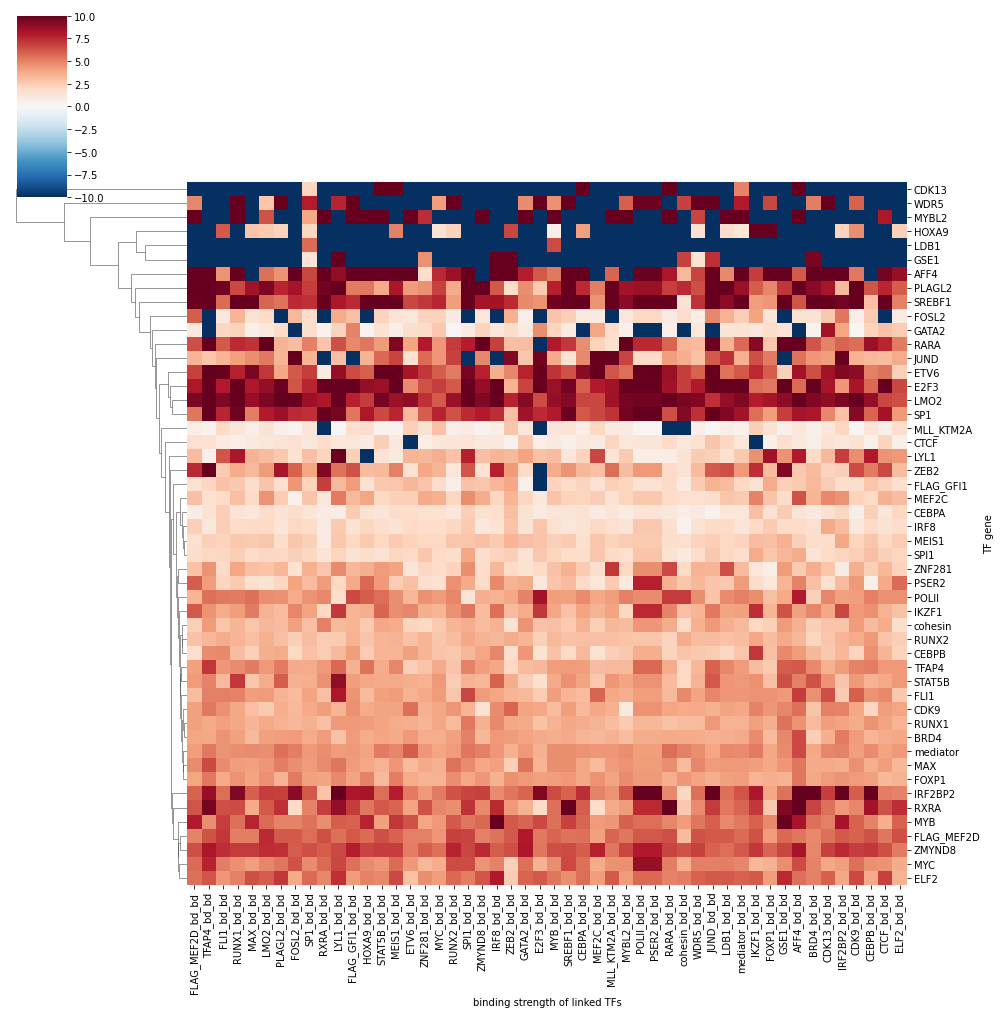

In [482]:
%matplolib inline

#### correlation in binding strength of linked TF

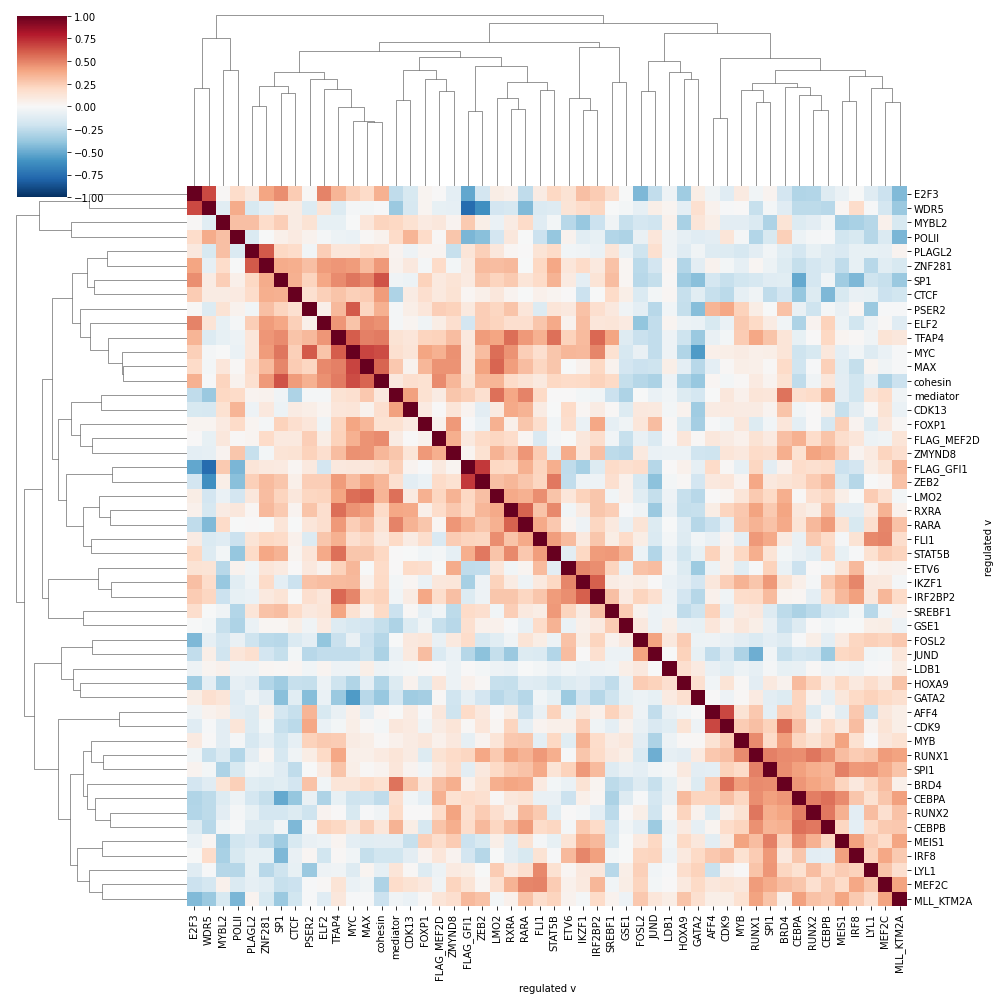

In [483]:
sns.clustermap(pd.DataFrame(data=np.corrcoef(pos), index=pos.index, columns=pos.index), figsize=(14,14), vmax=1, vmin=-1, cmap='RdBu_r')

#### using the sum

In [504]:
pos = pd.DataFrame(index=list(terms.keys()))
for val in list(terms.keys()):
    loc = merged.regulating.isin(set(allpredmapp[allpredmapp.TargetGene.str.contains(terms[val])].name))
    pos[val] = merged[loc][list(terms.keys())].sum() / merged[list(terms.keys())].mean()

In [505]:
pos.index.name = "regulated v"

In [133]:
from scipy.stats import zscore

In [498]:
lpos = pd.DataFrame(data=pos.values/pos.max(0).values, index=pos.index, columns=[val+'_bd' for val in pos.columns])

In [500]:
lpos[pos==0]=-1

In [501]:
p = sns.clustermap(lpos), figsize=(14,14), vmax=1, vmin=-1, col_cluster=0, cmap='RdBu_r')
ax = p.ax_heatmap
ax.set_xlabel('binding strength of linked TFs')
ax.set_ylabel('TF gene')

Text(983.9499999999998, 0.5, 'TF gene')

UsageError: Line magic function `%matplolib` not found.


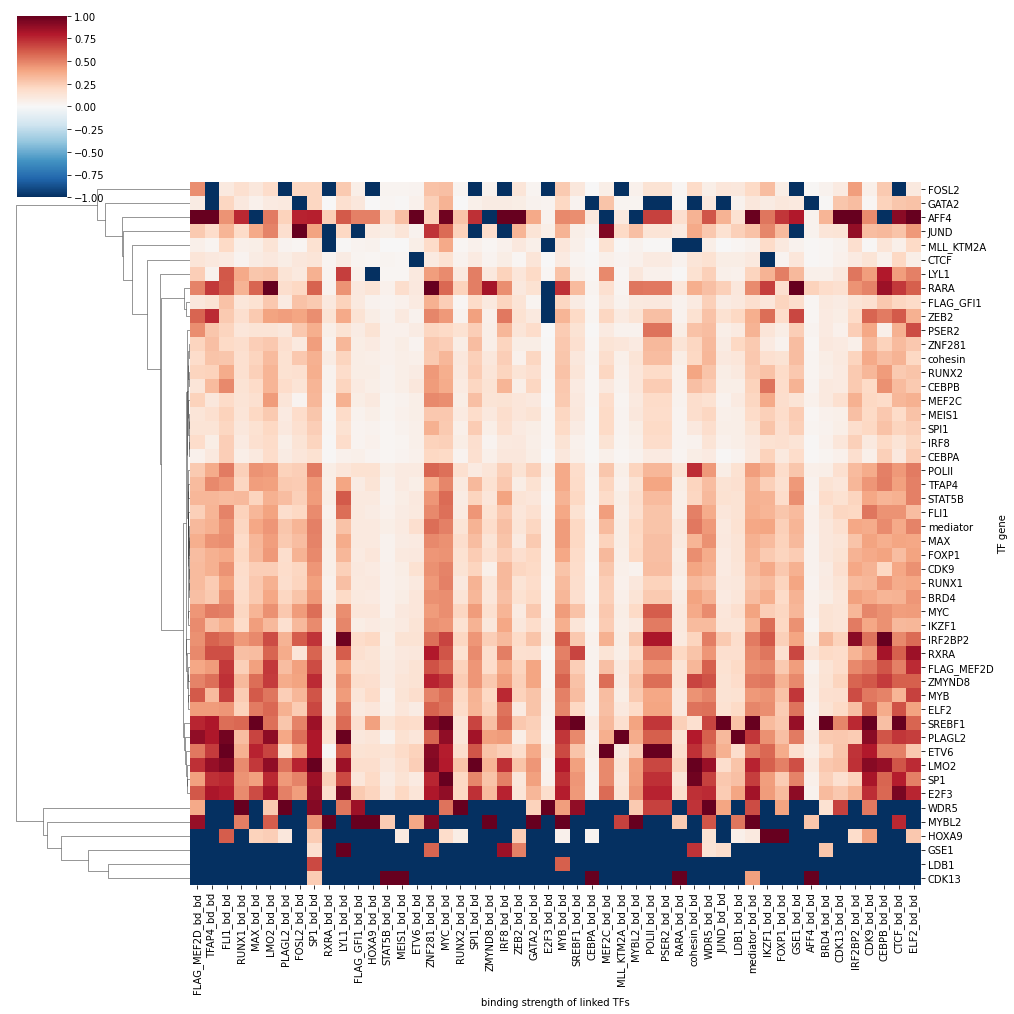

In [502]:
%matplolib inline

#### correlation in binding strength of linked TF

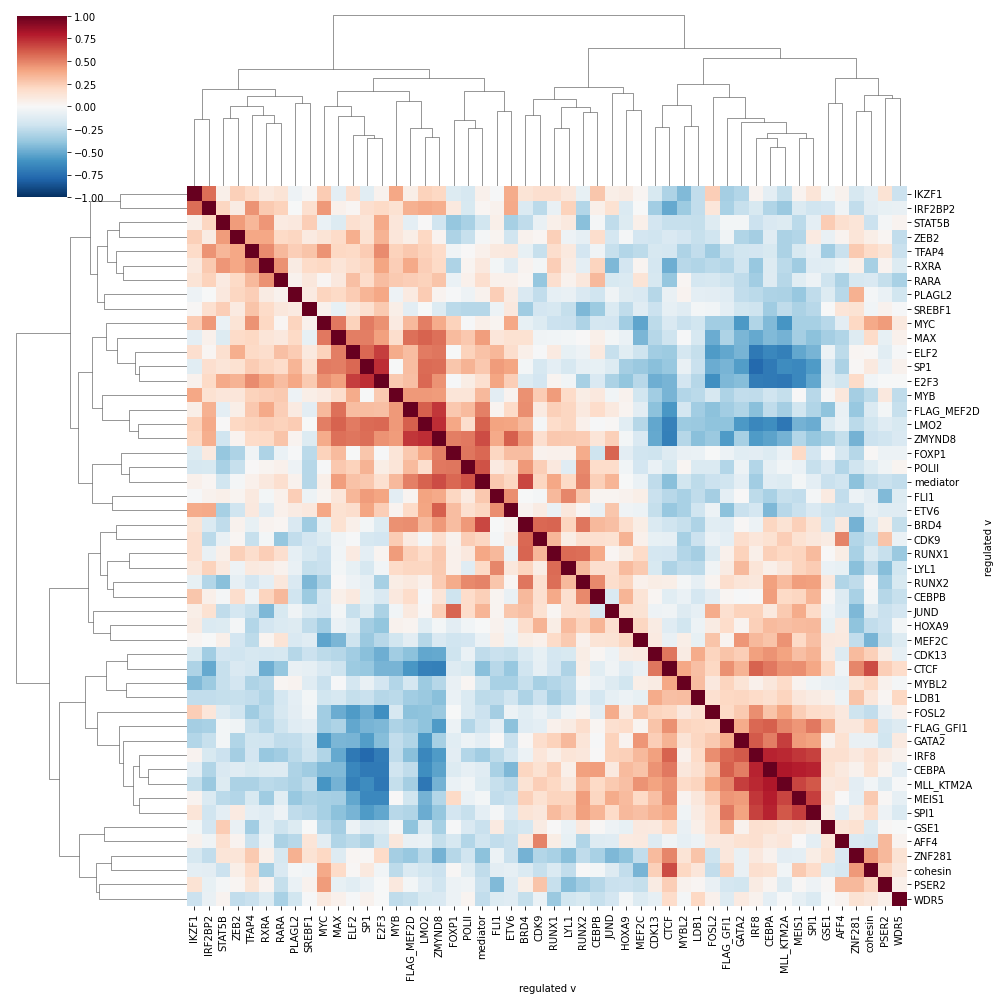

In [506]:
sns.clustermap(pd.DataFrame(data=np.corrcoef(zscore(pos)), index=pos.index, columns=pos.index), figsize=(14,14), vmax=1, vmin=-1, cmap='RdBu_r')

### making an adjacency graph

In [161]:
import networkx as nx

In [507]:
net = nx.from_pandas_adjacency(pd.DataFrame(data=zscore(pos)>0, index=pos.index, columns=pos.index).T,create_using=nx.DiGraph)
vis = nx.nx_agraph.graphviz_layout(net, prog="neato")

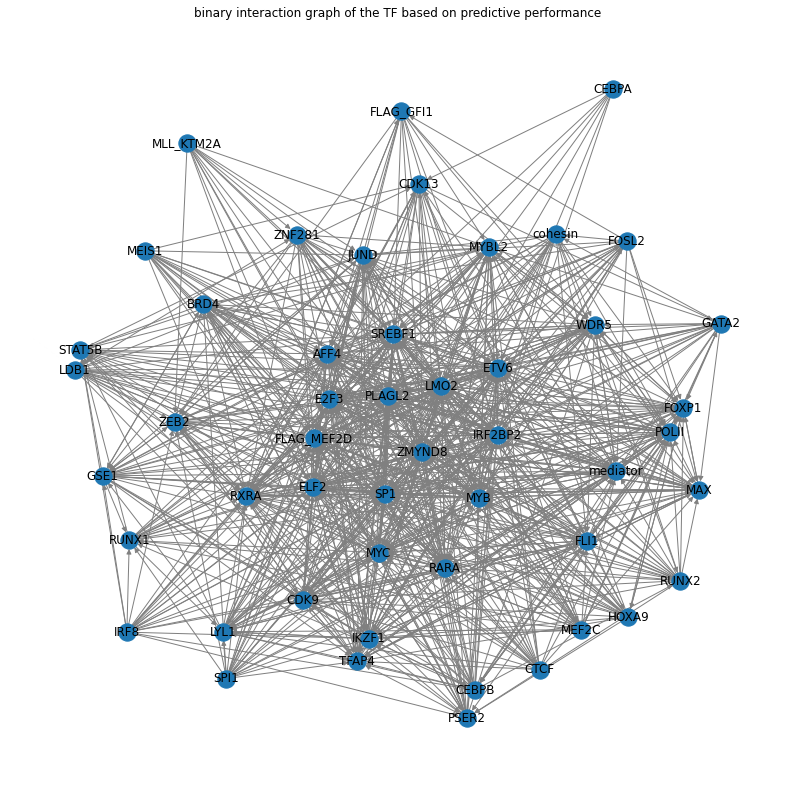

<Figure size 432x288 with 0 Axes>

In [508]:
plt.figure(figsize=(14, 14))
ax = plt.gca()
ax.set_title('binary interaction graph of the TF based on predictive performance')
nx.draw(net,vis,with_labels=True, edge_color="grey")
plt.show()
plt.savefig("../results/"+project+'/'+version+'_'+merging_version+'_'+window+"/plots/interaction_graph_max.pdf")

### prediction of degradation

In [203]:
myb_deg = pd.read_csv('../results/slamseq_MYB/MYB_degraded_timecourse_v1_MYB_1h_0_5_deseq_tccounts.csv')

In [205]:
myb_deg = myb_deg[myb_deg.padj<.05]

In [206]:
myb_deg

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
24,25.962450,1.820006,0.338091,-5.383184,7.317951e-08,5.447751e-06,ACAT2,ACAT2
49,16.805318,-1.597782,0.364828,4.379544,1.189278e-05,6.254657e-04,ADA,ADA
61,127.718947,-0.632612,0.188961,3.347836,8.144508e-04,2.289776e-02,ADCY9,ADCY9
81,23.258210,-1.271242,0.300508,4.230305,2.333746e-05,1.126485e-03,ADRB2,ADRB2
82,77.365900,-1.311092,0.200898,6.526143,6.748469e-11,9.030135e-09,GRK2,GRK2
...,...,...,...,...,...,...,...,...
17682,48.326684,-0.743209,0.219896,3.379815,7.253451e-04,2.083593e-02,LAMP5-AS1,LAMP5-AS1
17769,7.418330,-2.685903,0.625340,4.295110,1.746065e-05,8.706442e-04,LINC01585,LINC01585
17971,24.099188,-1.755290,0.312863,5.610406,2.018528e-08,1.720795e-06,MIR6774,MIR6774
18041,6.263459,-1.887272,0.590637,3.195316,1.396776e-03,3.592536e-02,AC138356.1,AC138356.1


In [261]:
allpredmapp[allpredmapp.TargetGene.str.contains(', ' + myb_deg.genes.values[0]+',')].TargetGene

7103     TMEM242, ZDHHC14, SNX9, SYNJ2, SYNJ2-IT1, SERA...
7104     SYNJ2, SYNJ2-IT1, SERAC1, GTF2H5, TULP4, TMEM1...
7110     SERAC1, GTF2H5, DYNLT1, EZR, C6orf99, RSPH3, T...
7112                SOD2, WTAP, ACAT2, TCP1, MRPL18, IGF2R
7113     EZR, SOD2, WTAP, ACAT2, TCP1, MRPL18, IGF2R, L...
7118     DYNLT1, EZR, C6orf99, RSPH3, TAGAP, SOD2, WTAP...
14541    SNX9, SYNJ2, SYNJ2-IT1, SERAC1, GTF2H5, TULP4,...
14542    SYNJ2, SYNJ2-IT1, SERAC1, GTF2H5, TULP4, TMEM1...
14543    SCAF8, TFB1M, LOC105378068, ARID1B, TMEM242, Z...
14544    TULP4, EZR, C6orf99, RSPH3, TAGAP, LOC10272405...
14546    DYNLT1, C6orf99, TAGAP, SOD2, ACAT2, TCP1, MRP...
14547     LOC102724053, ACAT2, TCP1, MRPL18, IGF2R, MAP3K4
14552     TAGAP, ACAT2, TCP1, MRPL18, IGF2R, LPAL2, MAP3K4
Name: TargetGene, dtype: object

In [305]:
mybtarg_allpredmapp = allpredmapp[allpredmapp.TargetGene.str.contains(', '+',|, '.join(myb_deg.genes)+',')]

In [449]:
allpredmapp

,name,chrom,start,end,TargetGene
0,genic|chr10:100009039-100010605,chr10,100009039,100010605,"R3HCC1L, PYROXD2"
1,genic|chr10:100184658-100187428,chr10,100184658,100187428,"PDLIM1, ENTPD1-AS1, ARHGAP19-SLIT1, ARHGAP19, ..."
2,genic|chr10:100228503-100229995,chr10,100228503,100229995,HPS1
3,genic|chr10:100285893-100287256,chr10,100285893,100287256,PYROXD2
4,genic|chr10:100346233-100347802,chr10,100346233,100347802,"MARVELD1, PYROXD2, HPS1"
...,...,...,...,...,...
17310,promoter|chrX:48916849-48918129,chrX,48916849,48918129,"FTSJ1, HDAC6, SLC35A2, GRIPAP1, TFE3, PRAF2, P..."
17311,promoter|chrX:48956792-48959178,chrX,48956792,48959178,"FUNDC1, KDM6A, KRBOX4, RP2, LINC01545, JADE3, ..."
17312,promoter|chrX:49042897-49044479,chrX,49042897,49044479,"PQBP1, TIMM17B, PIM2, OTUD5, GPKOW, PLP2, PRIC..."
17313,promoter|chrX:53713581-53715496,chrX,53713581,53715496,"TSPYL2, IQSEC2, SMC1A, HSD17B10, HUWE1, PHF8, ..."


In [450]:
mybtarg_allpredmapp[mybtarg_allpredmapp.name.str.contains('promoter')].iloc[0].TargetGene

'WAC-AS1, WAC, LINC00837, SVIL, KIAA1462, LOC101929279, MTPAP, MAP3K8, SVILP1, LOC105376480, ZNF438, LOC101929352, ARHGAP12, KIF5B, EPC1, ITGB1, CUL2, CREM, CCNY'

In [312]:
mybtarg_allpredmapp

,name,chrom,start,end,TargetGene
10,genic|chr10:101817307-101819364,chr10,101817307,101819364,"PGAM1, GOT1, LINC01475, DNMBP, CHUK, BLOC1S2, ..."
13,genic|chr10:102055152-102057034,chr10,102055152,102057034,"GOT1, ABCC2, DNMBP, ERLIN1, CHUK, CWF19L1, BLO..."
14,genic|chr10:102064658-102066738,chr10,102064658,102066738,"CUTC, COX15, ABCC2, CHUK, CWF19L1, BLOC1S2, SC..."
16,genic|chr10:102119710-102121221,chr10,102119710,102121221,"CWF19L1, BLOC1S2, SCD, OLMALINC, HIF1AN"
27,genic|chr10:103395664-103397834,chr10,103395664,103397834,"POLL, DPCD, FBXW4, NPM3, MGEA5, KCNIP2-AS1, HP..."
...,...,...,...,...,...
17292,promoter|chr9:38068105-38070225,chr9,38068105,38070225,"SHB, FAM95C, ZNF658"
17293,promoter|chr9:38392142-38393506,chr9,38392142,38393506,"TRMT10B, ALDH1B1, FAM95C, ZNF658"
17294,promoter|chr9:38620255-38622657,chr9,38620255,38622657,"ALDH1B1, FAM95C, ANKRD18A, FAM201A, ZNF658B, Z..."
17311,promoter|chrX:48956792-48959178,chrX,48956792,48959178,"FUNDC1, KDM6A, KRBOX4, RP2, LINC01545, JADE3, ..."


In [317]:
len(mybtarg_allpredmapp)

2240

In [313]:
merged_myb = merged[merged.MYB!=0]

In [316]:
len(merged_myb)

24088

In [315]:
len(set(merged_myb.regulating))

10736

In [318]:
len(set(merged_myb.regulating) & set(mybtarg_allpredmapp.name))

1723

In [321]:
len(set(merged_myb.regulating) & set(mybtarg_allpredmapp.name)) / len(mybtarg_allpredmapp)

0.7691964285714286

In [320]:
len(set(merged_myb.regulating) & set(allpredmapp.name)) / len(allpredmapp.name)

0.615824429685244

In [324]:
# with motif
merged_myb = merged[(merged.MYB!=0) & (merged.MYB_mot!=0)]
print("myb enhancers")
print(len(merged_myb))
print("myb enhancers in ABC")
print(len(set(merged_myb.regulating)))
print("myb enhancers in ABC that associate with gene reduced in MYB degron slamseq")
print(len(set(merged_myb.regulating) & set(mybtarg_allpredmapp.name)))
print("myb enhancers in ABC that associate with gene reduced in MYB degron slamseq (% compared to total gene reduced)")
print(len(set(merged_myb.regulating) & set(mybtarg_allpredmapp.name)) / len(mybtarg_allpredmapp))
print("enhancers in ABC that associate with enhancers in cob (%)")
print(len(set(merged_myb.regulating) & set(allpredmapp.name)) / len(allpredmapp.name))

myb enhancers
7054
myb enhancers in ABC
3349
myb enhancers in ABC that associate with gene reduced in MYB degron slamseq
621
myb enhancers in ABC that associate with gene reduced in MYB degron slamseq (% compared to total gene reduced)
0.27723214285714287
enhancers in ABC that associate with enhancers in cob (%)
0.19116373086918856


In [ ]:
### doing it the other way around

In [378]:
merged_myb = merged[(merged.MYB!=0) & (merged.MYB_mot!=0) & (merged.regulating!='')]

In [379]:
mybtarg_allpredmapp = allpredmapp[allpredmapp.name.isin(merged_myb.regulating)]

In [347]:
mybtarg_allpredmapp

,name,chrom,start,end,TargetGene
0,genic|chr10:100184658-100187428,chr10,100184658,100187428,"PYROXD2, HPS1"
13,genic|chr10:103192097-103193887,chr10,103192097,103193887,BTRC
18,genic|chr10:103917336-103919137,chr10,103917336,103919137,"PPRC1, NOLC1, ELOVL3, GBF1"
19,genic|chr10:104120561-104122996,chr10,104120561,104122996,"CUTC, COX15, MGEA5, KCNIP2-AS1, HPS6, LDB1, PP..."
28,genic|chr10:106836411-106837955,chr10,106836411,106837955,LOC101927549
...,...,...,...,...,...
12618,promoter|chr9:5626681-5630149,chr9,5626681,5630149,"RFX3-AS1, PLPP6, CDC37L1-AS1, CDC37L1, PLGRKT,..."
12619,promoter|chr9:5832341-5833623,chr9,5832341,5833623,ERMP1
12620,promoter|chr9:6006700-6009143,chr9,6006700,6009143,"KIAA2026, RANBP6, PTPRD-AS1, LOC105375972, PTP..."
12623,promoter|chr9:6756480-6759616,chr9,6756480,6759616,"KDM4C, TMEM261, PTPRD-AS1, LOC105375972, PTPRD..."


In [349]:
len(set(', '.join(mybtarg_allpredmapp.TargetGene.values).split(', ')))

8406

In [363]:
merged_myb

,chrom,start,end,peak_number,foldchange,-log10pvalue,-log10qvalue,relative_summit_pos,open regions,super_enhancer,...,CTCF_mot,FOSL2_mot,IKZF1_mot,FOXP1_mot,HOXA9_mot,TFAP4_mot,SPI1_mot,ZNF281_mot,FLAG_MEF2D_mot,regulating
51,chr1,1115873,1117780,45,7.25583,0.0,0.0,1115873,7.25583,0.0,...,45.300000,0.00,0.0,0.0,0.0,42.60,66.2,0.000000,0.0,genic|chr1:1115576-1117210
65,chr1,1212791,1213828,58,3.44226,0.0,0.0,1212791,3.44226,0.0,...,41.400000,0.00,0.0,0.0,0.0,42.35,0.0,52.850000,0.0,intergenic|chr1:1212415-1214054
87,chr1,1374962,1375730,76,5.43490,0.0,0.0,1374962,5.43490,0.0,...,41.400000,0.00,49.2,0.0,0.0,0.00,0.0,0.000000,0.0,genic|chr1:1374368-1377203
117,chr1,1574065,1575368,101,7.55235,0.0,0.0,1574065,7.55235,0.0,...,46.233333,0.00,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,genic|chr1:1573797-1575610
148,chr1,1778184,1780671,128,4.09033,0.0,0.0,1778184,4.09033,0.0,...,44.162500,0.00,0.0,0.0,0.0,40.50,0.0,53.850000,0.0,genic|chr1:1777515-1781134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151415,chrX,154295073,154296020,128990,3.53528,0.0,0.0,154295073,3.53528,0.0,...,0.000000,0.00,0.0,0.0,0.0,0.00,0.0,68.366667,0.0,genic|chrX:154294880-154296578
151424,chrX,154368462,154369613,128999,3.38354,0.0,0.0,154368462,3.38354,0.0,...,42.660000,44.15,49.2,0.0,0.0,40.85,55.4,56.283333,0.0,intergenic|chrX:154368109-154369841
151427,chrX,154378343,154379608,129001,6.68677,0.0,0.0,154378343,6.68677,0.0,...,48.450000,0.00,0.0,0.0,0.0,0.00,0.0,63.980000,0.0,intergenic|chrX:154377999-154380047
151435,chrX,154427425,154429056,129008,4.79898,0.0,0.0,154427425,4.79898,0.0,...,0.000000,41.10,0.0,0.0,0.0,0.00,69.5,0.000000,43.3,intergenic|chrX:154427880-154429174


In [350]:
len(merged_myb)

3366

In [390]:
myb_deg

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
24,25.962450,1.820006,0.338091,-5.383184,7.317951e-08,5.447751e-06,ACAT2,ACAT2
49,16.805318,-1.597782,0.364828,4.379544,1.189278e-05,6.254657e-04,ADA,ADA
61,127.718947,-0.632612,0.188961,3.347836,8.144508e-04,2.289776e-02,ADCY9,ADCY9
81,23.258210,-1.271242,0.300508,4.230305,2.333746e-05,1.126485e-03,ADRB2,ADRB2
82,77.365900,-1.311092,0.200898,6.526143,6.748469e-11,9.030135e-09,GRK2,GRK2
...,...,...,...,...,...,...,...,...
17682,48.326684,-0.743209,0.219896,3.379815,7.253451e-04,2.083593e-02,LAMP5-AS1,LAMP5-AS1
17769,7.418330,-2.685903,0.625340,4.295110,1.746065e-05,8.706442e-04,LINC01585,LINC01585
17971,24.099188,-1.755290,0.312863,5.610406,2.018528e-08,1.720795e-06,MIR6774,MIR6774
18041,6.263459,-1.887272,0.590637,3.195316,1.396776e-03,3.592536e-02,AC138356.1,AC138356.1


In [380]:
res = {val: mybtarg_allpredmapp[mybtarg_allpredmapp.TargetGene.str.contains(', ' + val+',')].index.tolist() for val in myb_deg.genes}

In [429]:
merged_myb.columns[-34:-1]

Index(['promoter', 'RUNX2_mot', 'MYB_mot', 'GATA2_mot', 'ZEB2_mot', 'IRF8_mot',
       'MAX_mot', 'STAT5B_mot', 'E2F3_mot', 'SREBF1_mot', 'SP1_mot',
       'FLI1_mot', 'MEF2C_mot', 'CEBPA_mot', 'MYC_mot', 'RARA_mot',
       'CEBPB_mot', 'MEIS1_mot', 'RUNX1_mot', 'ETV6_mot', 'LYL1_mot',
       'RXRA_mot', 'ELF2_mot', 'JUND_mot', 'CTCF_mot', 'FOSL2_mot',
       'IKZF1_mot', 'FOXP1_mot', 'HOXA9_mot', 'TFAP4_mot', 'SPI1_mot',
       'ZNF281_mot', 'FLAG_MEF2D_mot'],
      dtype='object')

<AxesSubplot:>

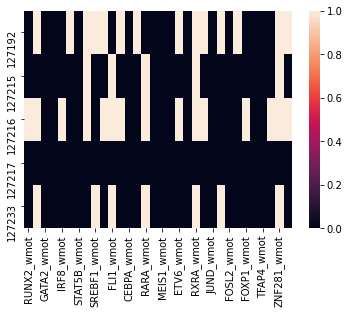

In [438]:
sns.heatmap(merged[merged.regulating.isin(mybtarg_allpredmapp.loc[res['SNHG15']].name)][merged.columns[-32:]].astype(bool))

In [434]:
print(len(merged))
for val in merged.columns[-33:-1]:
    val = val[:-4]
    print('--------------')
    print(val)
    print("no binding but mot: ", len(merged[(merged[val]==0) & (merged[val+"_mot"]!=0)]))
    print("binding and mot:", len(merged[(merged[val]!=0) & (merged[val+"_mot"]!=0)]))
    print("binding no mot:", len(merged[(merged[val]!=0) & (merged[val+"_mot"]==0)]))

151813
--------------
RUNX2
no binding but mot:  8255
binding and mot: 29229
binding no mot: 40525
--------------
MYB
no binding but mot:  10143
binding and mot: 7054
binding no mot: 17034
--------------
GATA2
no binding but mot:  13017
binding and mot: 3919
binding no mot: 5970
--------------
ZEB2
no binding but mot:  16479
binding and mot: 3633
binding no mot: 4147
--------------
IRF8
no binding but mot:  5258
binding and mot: 19546
binding no mot: 36762
--------------
MAX
no binding but mot:  2970
binding and mot: 13023
binding no mot: 53695
--------------
STAT5B
no binding but mot:  10922
binding and mot: 7186
binding no mot: 21161
--------------
E2F3
no binding but mot:  14600
binding and mot: 8462
binding no mot: 6264
--------------
SREBF1
no binding but mot:  21467
binding and mot: 1694
binding no mot: 2413
--------------
SP1
no binding but mot:  5123
binding and mot: 13337
binding no mot: 10333
--------------
FLI1
no binding but mot:  8775
binding and mot: 16415
binding no mot:

In [435]:
for val in merged.columns[-33:-1]:
    val = val[:-4]
    merged[val+"_wmot"] = merged[(merged[val]!=0) & (merged[val+"_mot"]!=0)][val]
merged = merged.fillna(0)

In [381]:
res

{'ACAT2': [7110, 7118, 14544, 14546],
 'ADA': [4691],
 'ADCY9': [2227],
 'ADRB2': [6748, 14109],
 'GRK2': [700],
 'CRYBG1': [],
 'AK2': [4305, 11978, 11985],
 'ARHGAP1': [600, 606],
 'ARHGDIB': [1037, 9408, 9452, 9477],
 'ARRB2': [10840],
 'ATF4': [],
 'ATP2B4': [11750],
 'ATP6V1B2': [7935, 7943, 7946],
 'AZU1': [11445, 16688, 16689],
 'PRDM1': [],
 'ZFP36L2': [5530, 13078, 13079],
 'KLF9': [15817],
 'LDLRAD4': [16447],
 'CALM3': [3454],
 'CALR': [],
 'CAT': [559, 9120, 9121, 9123, 9124],
 'CCND3': [7237, 7243, 14714, 17101],
 'CCNG1': [14158],
 'MS4A3': [9188, 9195],
 'CD36': [7734],
 'CDC5L': [7272, 14733, 17101],
 'CDK9': [15732, 17192],
 'CEBPA': [],
 'CHD3': [],
 'CHI3L1': [11750],
 'CHML': [4215, 4221, 4222, 16750],
 'CLIC1': [7172, 7174, 7177],
 'CCR1': [],
 'KLF6': [],
 'CPM': [9617, 9620],
 'CTSG': [],
 'CTSZ': [4740, 12349, 12363, 12366, 12371],
 'CX3CR1': [6086, 13514],
 'CYB5A': [3087, 3089, 3092, 11100, 11102, 11108],
 'CYP51A1': [7756],
 'DAP': [],
 'CFD': [16688],
 'DHCR

In [402]:
merged_myb.columns[cols+2:-43]

Index(['FLAG_MEF2D', 'TFAP4', 'FLI1', 'RUNX1', 'MAX', 'LMO2', 'PLAGL2',
       'FOSL2', 'SP1', 'RXRA', 'LYL1', 'FLAG_GFI1', 'HOXA9', 'STAT5B', 'MEIS1',
       'ETV6', 'ZNF281', 'MYC', 'RUNX2', 'SPI1', 'ZMYND8', 'IRF8', 'ZEB2',
       'GATA2', 'E2F3', 'MYB', 'SREBF1', 'CEBPA', 'MEF2C', 'MLL_KTM2A',
       'MYBL2', 'POLII', 'PSER2', 'RARA', 'cohesin', 'WDR5', 'JUND', 'LDB1',
       'mediator', 'IKZF1', 'FOXP1', 'GSE1', 'AFF4', 'BRD4', 'CDK13',
       'IRF2BP2', 'CDK9', 'CEBPB', 'CTCF', 'ELF2'],
      dtype='object')

In [403]:
merged[(merged.MYB!=0) & (merged.MYB_mot!=0) & (merged.regulating!='')][merged.columns[cols+2:-43]].astype(bool).sum(1).mean()

28.140819964349376

In [410]:
merged[(merged.MYB!=0) & (merged.regulating!='')][merged.columns[cols+2:-43]].astype(bool).sum(1).mean()

27.466092375366568

In [406]:
merged[merged.regulating!=""][merged.columns[cols+2:-43]].astype(bool).sum(1).mean()

23.24328079080951

In [418]:
merged[(merged.MYB!=0)][merged.columns[cols+2:-43]].astype(bool).sum(1).mean()

21.518432414480237

In [407]:
merged[merged.columns[cols+2:-43]].astype(bool).sum(1).mean()

8.529743829579813

In [414]:
merged[(merged.IRF2BP2!=0) & (merged.regulating!='')][merged.columns[cols+2:-43]].astype(bool).sum(1).mean()

30.029468177855275

In [417]:
merged[(merged.FOXP1!=0) & (merged.FOXP1_mot!=0) & (merged.regulating!='')][merged.columns[cols+2:-43]].astype(bool).sum(1).mean()

26.053955643826548

In [416]:
crc

['CEBPA',
 'E2F3',
 'FLI1',
 'FOSL2',
 'GFI1',
 'HEX',
 'IRF8',
 'LYL1',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MYB',
 'PLAGL2',
 'RUNX1',
 'RUNX2',
 'RXRA',
 'SP1',
 'SPI1',
 'SREBF1',
 'STAT5B',
 'TFAP4',
 'ZEB2',
 'ZFPM1',
 'ZNF281',
 'LMO2',
 'ZMYND8',
 'GATA2',
 'MAX',
 'MYC',
 'ETV6',
 'HOXA9']

In [372]:
res

{'ACAT2': [],
 'ADA': [],
 'ADCY9': [],
 'ADRB2': [4942],
 'GRK2': [],
 'CRYBG1': [],
 'AK2': [],
 'ARHGAP1': [],
 'ARHGDIB': [739, 6886],
 'ARRB2': [],
 'ATF4': [],
 'ATP2B4': [],
 'ATP6V1B2': [],
 'AZU1': [8260, 12030],
 'PRDM1': [],
 'ZFP36L2': [9387],
 'KLF9': [],
 'LDLRAD4': [],
 'CALM3': [],
 'CALR': [],
 'CAT': [],
 'CCND3': [],
 'CCNG1': [10144],
 'MS4A3': [],
 'CD36': [],
 'CDC5L': [],
 'CDK9': [12510],
 'CEBPA': [],
 'CHD3': [],
 'CHI3L1': [],
 'CHML': [3086, 12087],
 'CLIC1': [5235],
 'CCR1': [],
 'KLF6': [],
 'CPM': [],
 'CTSG': [],
 'CTSZ': [],
 'CX3CR1': [4433],
 'CYB5A': [2251, 2256, 8026, 8028],
 'CYP51A1': [5694],
 'DAP': [],
 'CFD': [12030],
 'DHCR24': [3229],
 'DIAPH1': [],
 'HBEGF': [],
 'EGR3': [],
 'ELANE': [8260, 12030],
 'EMP1': [],
 'EPOR': [],
 'ERN1': [],
 'ETS2': [],
 'F3': [3310, 8744, 8747, 8751],
 'FDFT1': [10916],
 'FOSL2': [],
 'FTH1': [],
 'FTL': [],
 'FUT4': [606, 610, 6810],
 'FUT7': [],
 'GALNT1': [7961],
 'GCH1': [],
 'GFI1': [3310, 8744, 8747],
 '

In [370]:
    mybtarg_allpredmapp[mybtarg_allpredmapp.TargetGene.str.contains(', ' + myb_deg.genes.values[2]+',')].index.tolist()

[]

In [ ]:
pos = pd.DataFrame(index=list(terms.keys()))
for val in list(terms.keys()):
    loc = merged.regulating.isin(set(allpredmapp[allpredmapp.TargetGene.str.contains(terms[val])].name))
    pos[val] = merged[loc][list(terms.keys())].mean() / merged[list(terms.keys())].mean()

In [ ]:
#### what genes is any of our binder, regulating?

### can we use histone marks to guess whether it is up or down regulation?

### do we have different codes (set of values) in up vs down histone marks?

In [ ]:
### redo the plots. do we get better looking plots?

In [ ]:
### compare presence of CTCF and transcription of linked RNA

## Predict

In [ ]:
## enrichment at the gene set level

In [ ]:
## are our cobinding clusters enriched in some sets of genes / CRC? 

In [ ]:
## make a linear model to with marks and cobinding data + motifs and TFs+cobinding motifs + expression of cobound proteins + expression , can we predict expression/dependenccy?

In [ ]:
## can we predict better for some set of genes / CRCs?

In [ ]:
## do the same on closest expressed gene

In [ ]:
## do this prediction on each enhancer.what is the best predicting enhancer? do that correlate with ABC model data?

In [ ]:
## do we get, for some gene, better single enhancer prediction?

In [ ]:
## what are the gene sets enriched in each clusters?? (based on TF cobinding or based on TF cobinding + )

## RNP data

In [ ]:
## can we predict RNP data (setting this TF to zero and lookingg at expected RNA change)
## do we see genes with opposite effects? 

In [ ]:
## if we add RNP data, can we increase our model's prediction? (we have expression change and we set all RNPed-TF values to 0) 

In [ ]:
### to predict remaining X% RNA expression
### to predict remaining X TFs RNP
### to predict regular RNA expression

In [ ]:
## same thing with filtering base on motif presence (actual DNA binding)
## same thing with closest expressed gene

In [ ]:
## Do on all cell lines

In [ ]:
## repeat the process across all samples with H3K27ac+RNAseq data we have.

In [ ]:
## call mutations from H3k27ac data

In [ ]:
## MEME analysis of likely bound TFs, except if TF is not expressed

In [ ]:
## compute enrichments

In [ ]:
## from same gene assignements, as found on the general consensus peak set, can we find good dependency/expression prediction

### Compare data with other labs (H3K27, HiC..)

we need to redo everything for similar normal cell type, getting TFs based on the CRC (find it with CRCmapper or on litterature)